# Data Analysis Notebook

---



## 1. Installs, imports and loading modules

In [ ]:
### Installations and imports ###

!pip install simpletransformers
!pip install tensorboardx

import random
import os
from urllib import request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk

#Imports for Transformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from sklearn.preprocessing import MultiLabelBinarizer
from urllib import request
import pandas as pd
import logging
import torch
torch.manual_seed(42)
from collections import Counter
from ast import literal_eval

In [ ]:
### Don't Patronise Me Dataset ###

# Mount on G Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Prepare the logger
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Check GPU
cuda_available = torch.cuda.is_available()
print('Cuda available? ',cuda_available)
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

# Load the data module
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# Load the official evaluator
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# Helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')

Cuda available?  False
Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


## 2. Load Task 1 data and train/test set


In [ ]:
# Load task 1 data
dpm.load_task1()

# Access data as a dataframe
train_df = dpm.train_task1_df
train_df.head()

# Load the train and test set
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids

,par_id,label
0,4046,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...
2089,10462,"[0, 0, 0, 0, 0, 0, 0]"
2090,10463,"[0, 0, 0, 0, 0, 0, 0]"
2091,10464,"[0, 0, 0, 0, 0, 0, 0]"
2092,10465,"[0, 0, 0, 0, 0, 0, 0]"


## 3. Data Analysis

In [ ]:
# Get length of the training set
print(f'The length of the training set is {len(train_df)}')

# Binary class counts
train_df['label'].value_counts()
print(f'The number of examples with label 0 is {train_df["label"].value_counts()[0]}')
print(f'The number of examples with label 1 is {train_df["label"].value_counts()[1]}')

# Multiclass class counts
train_df['orig_label'].value_counts()
print(f'The number of examples with label 0 is {train_df["orig_label"].value_counts()[0]}')
print(f'The number of examples with label 1 is {train_df["orig_label"].value_counts()[1]}')
print(f'The number of examples with label 2 is {train_df["orig_label"].value_counts()[2]}')
print(f'The number of examples with label 3 is {train_df["orig_label"].value_counts()[3]}')
print(f'The number of examples with label 4 is {train_df["orig_label"].value_counts()[4]}')
print(f'Labels 0 and 1 are combined to form binary label 0 -> Not patronizing')
print(f'Labels 2, 3, and 4 are combined to form binary label 1 -> Patronizing')

# Keyword counts
train_df['keyword'].value_counts()

The length of the training set is 10469
The number of examples with label 0 is 9476
The number of examples with label 1 is 993
The number of examples with label 0 is 8529
The number of examples with label 1 is 947
The number of examples with label 2 is 458
The number of examples with label 3 is 391
The number of examples with label 4 is 144
Labels 0 and 1 are combined to form binary label 0 -> Not patronizing
Labels 2, 3, and 4 are combined to form binary label 1 -> Patronizing


migrant          1089
in-need          1082
vulnerable       1080
homeless         1077
women            1070
refugee          1068
immigrant        1061
disabled         1028
hopeless         1005
poor-families     909
Name: keyword, dtype: int64

In [ ]:
###  How frequent are the class labels? ###

# Get the number of class labels in the training set and place them in a pandas dataframe. Calculate percentage of each class label in the training set.
import pandas as pd
labels = train_df['orig_label'].value_counts()
labels = pd.DataFrame(labels)
labels = labels.reset_index()
labels.columns = ['label', 'count']
labels['percentage'] = round(((labels['count']/labels['count'].sum())*100),2)
labels

,label,count,percentage
0,0,8529,81.47
1,1,947,9.05
2,3,458,4.37
3,4,391,3.73
4,2,144,1.38


In [ ]:
df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


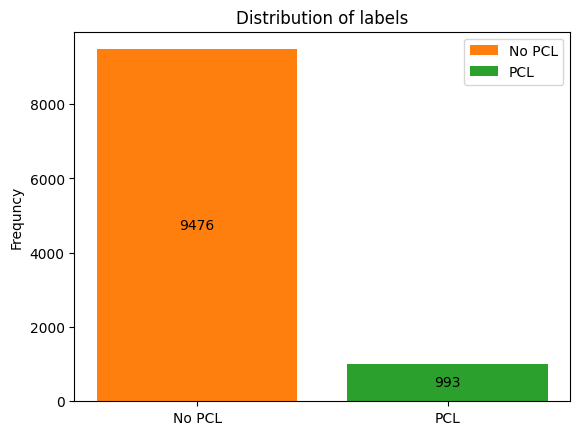

In [ ]:
import plotly
import plotly.graph_objects as go
df = train_df
# Distribution of labels


fig, ax = plt.subplots()

x_labels = ['No PCL', 'PCL']
counts = [len(df[(df["label"] == 0)]), len(df[(df["label"] == 1)])]
bar_colors = ['tab:orange', 'tab:green']
p = ax.bar(x_labels, counts, label=x_labels, color=bar_colors)
ax.bar_label(p, label_type='center')

ax.set_ylabel('Frequncy')
ax.set_title('Distribution of labels')
ax.legend()

plt.show()

([<matplotlib.patches.Wedge at 0x78d91806ebc0>,
 [Text(-0.9188184041466805, 0.6047914848948749, 'Class 0'),
  Text(0.7008997983677651, -0.8477850391744516, 'Class 1'),
  Text(0.9864579216374691, -0.48672453075501027, 'Class 3'),
  Text(1.0772150310125892, -0.22272803362070737, 'Class 4'),
  Text(1.0989663809974475, -0.04767487217993819, 'Class 2')],
 [Text(-1.3364631333042625, 0.8796967053016362, '81.5%'),
  Text(1.0194906158076582, -1.2331418751628387, '9.0%'),
  Text(1.4348478860181368, -0.7079629538254695, '4.4%'),
  Text(1.5668582269274023, -0.3239680489028471, '3.7%'),
  Text(1.5984965541781053, -0.06934526862536464, '1.4%')])

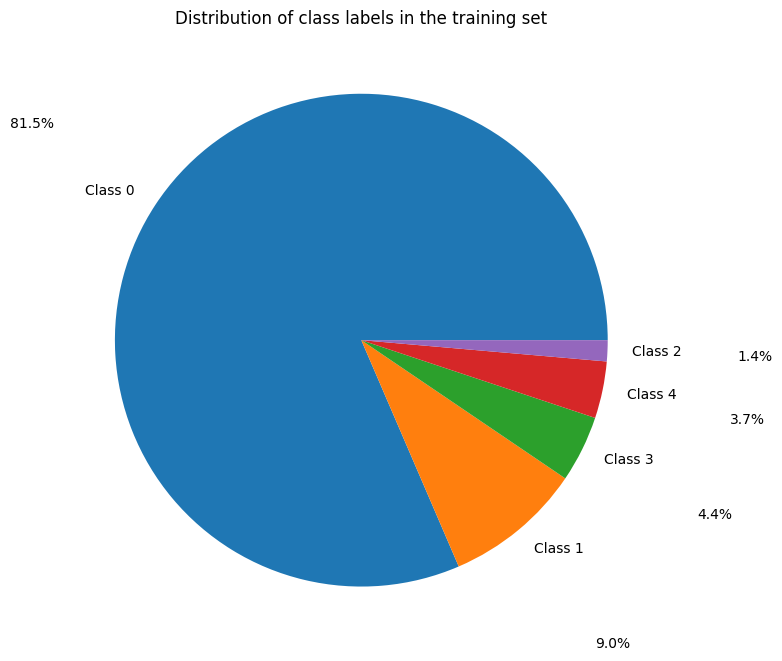

In [ ]:
class_labels = []
for label in labels['label']:
  class_labels.append(f"Class {label}")

plt.figure(figsize=(10, 8))
plt.title('Distribution of class labels in the training set')
plt.pie(x = labels['percentage'], labels = class_labels, autopct='%1.1f%%', pctdistance=1.6)

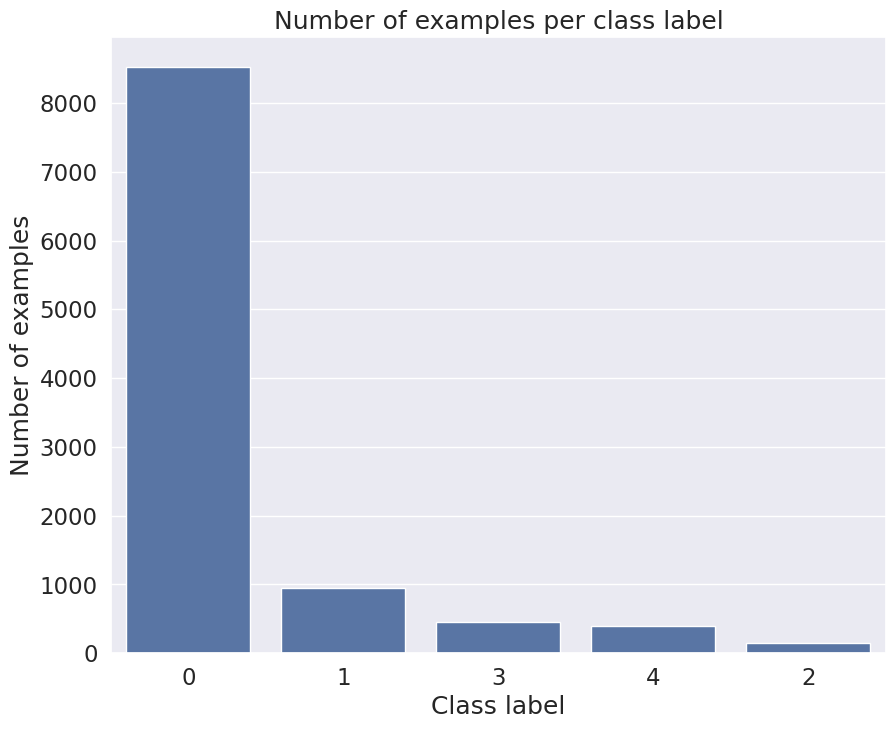

In [ ]:
### Show the correlation between the class labels and text length ###

sns.set_style('whitegrid')
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
sns.barplot(x='label', y='count', data=labels)
plt.title('Number of examples per class label')
plt.xlabel('Class label')
plt.ylabel('Number of examples')
plt.show()

In [ ]:
# Create a new annotated train_df with text length for each example
annotated_train_df = train_df.copy()
annotated_train_df['text_length'] = train_df['text'].apply(lambda x: len(x))

# Create one hot vectors for each keyword in the annotated_train_df
mlb = MultiLabelBinarizer()
annotated_train_df['keyword'] = annotated_train_df['keyword'].apply(lambda x: [x])
annotated_train_df = annotated_train_df.join(pd.DataFrame(mlb.fit_transform(annotated_train_df.pop('keyword')),
                            columns=mlb.classes_,
                            index=annotated_train_df.index))

# Get the stopwords
nltk.download('stopwords')

# Count the number of stop words in each text column
from nltk.corpus import stopwords
stop = stopwords.words('english')
annotated_train_df['stopwords'] = annotated_train_df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
annotated_train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,par_id,art_id,country,text,label,orig_label,text_length,disabled,homeless,hopeless,immigrant,in-need,migrant,poor-families,refugee,vulnerable,women,stopwords
0,1,@@24942188,ph,"We 're living in times of absolute insanity , ...",0,0,620,0,0,1,0,0,0,0,0,0,0,46
1,2,@@21968160,gh,"In Libya today , there are countless number of...",0,0,237,0,0,0,0,0,1,0,0,0,0,14
2,3,@@16584954,ie,"""White House press secretary Sean Spicer said ...",0,0,162,0,0,0,1,0,0,0,0,0,0,7
3,4,@@7811231,nz,Council customers only signs would be displaye...,0,0,162,1,0,0,0,0,0,0,0,0,0,10
4,5,@@1494111,ca,""""""" Just like we received migrants fleeing El ...",0,0,277,0,0,0,0,0,0,0,1,0,0,14


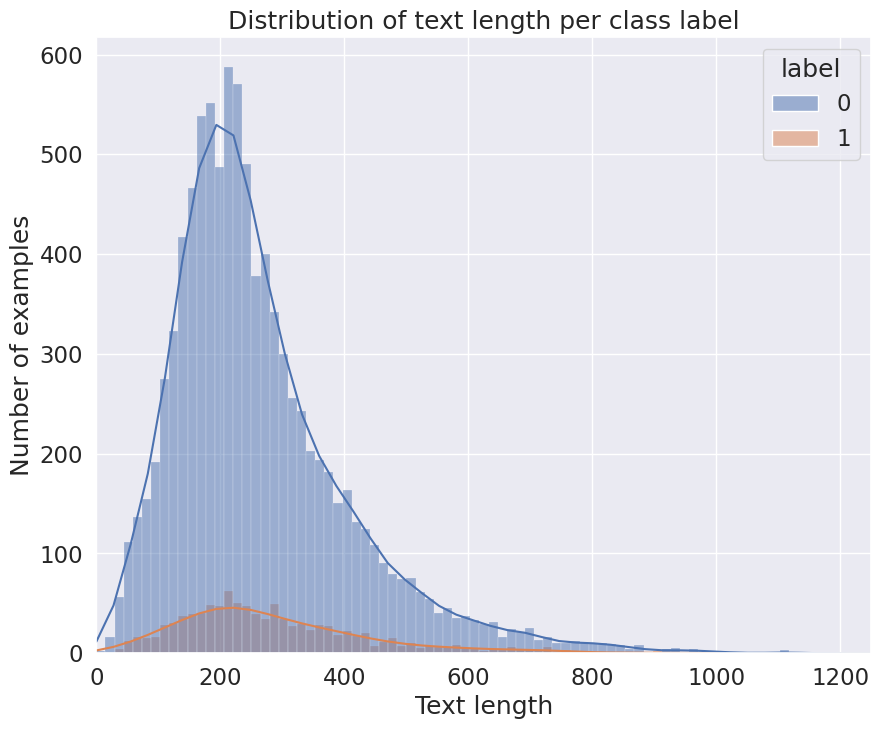

The maximum text length is 5501
The minimum text length is 0


In [ ]:
# Plot the distribution of the length of the text for each class label in the annotated_train_df in a histogram
plt.figure(figsize=(10, 8))
sns.histplot(x='text_length', data=annotated_train_df, hue='label', kde=True)
plt.title('Distribution of text length per class label')
plt.xlabel('Text length')
plt.ylabel('Number of examples')
plt.xlim(xmin=0, xmax=1250)
plt.show()

# get the max text length from the annotated_train_df
max_text_length = annotated_train_df['text_length'].max()
print(f'The maximum text length is {max_text_length}')

# Get the min text length from the annotated_train_df
min_text_length = annotated_train_df['text_length'].min()
print(f'The minimum text length is {min_text_length}')

# 4. Qualitative Assessment

In [ ]:
print("Label 0:", train_df[train_df['orig_label'] == '0'][train_df['keyword'] == 'homeless']['text'][22])

Label 0: """ It highlights that different communities respond to the issue of homelessness in different ways , "" Kneebone said ."


<ipython-input-12-b9e6a43f3109>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Label 0:", train_df[train_df['orig_label'] == '0'][train_df['keyword'] == 'homeless']['text'][22])


In [ ]:
print("Label 1:", train_df[train_df['orig_label'] == '1'][train_df['keyword'] == 'homeless']['text'][111])


Label 1: She has turned her modest home into a safe haven for the vulnerable , especially the elderly who find themselves homeless and living on the streets .


<ipython-input-13-87384c08acef>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Label 1:", train_df[train_df['orig_label'] == '1'][train_df['keyword'] == 'homeless']['text'][111])


In [ ]:
print("Label 2:", train_df[train_df['orig_label'] == '2'][train_df['keyword'] == 'homeless']['text'][1419])


Label 2: """ Every year I try to get somebody to help me to give some food to some homeless people , "" he continued ."


<ipython-input-14-1cedc0988caa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Label 2:", train_df[train_df['orig_label'] == '2'][train_df['keyword'] == 'homeless']['text'][1419])


In [ ]:
print("Label 3:", train_df[train_df['orig_label'] == '3'][train_df['keyword'] == 'homeless']['text'][76])

Label 3: In September , Major Nottle set off on foot from Melbourne to Canberra to plead for a national solution to the homeless problem .


<ipython-input-15-cf3f020c168a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Label 3:", train_df[train_df['orig_label'] == '3'][train_df['keyword'] == 'homeless']['text'][76])


In [ ]:
print("Label 4:", train_df[train_df['orig_label'] == '4'][train_df['keyword'] == 'homeless']['text'][337])

Label 4: Imagine being a homeless person , walking the streets of downtown Calgary on bitterly cold evenings .


<ipython-input-16-4e7aa0f58dfd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Label 4:", train_df[train_df['orig_label'] == '4'][train_df['keyword'] == 'homeless']['text'][337])


In [ ]:
df = train_df
# Label per type of article
article_type = np.unique(df["keyword"])
fig = go.Figure(data=[
    go.Bar(
        name="No PCL",
        x=article_type,
        y=[len(df[(df["keyword"] == c) & (df["label"] == 0)]) for c in article_type]
    ),
    go.Bar(
        name="PCL",
        x=article_type,
        y=[len(df[(df["keyword"] == c) & (df["label"] == 1)]) for c in article_type]
    ),
])
fig.update_layout(
    barmode="group",
    showlegend=True,
    title_text="Distribution per article type",
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()



In [ ]:
import plotly
import plotly.graph_objects as go

df = train_df
# Label per country code
country_codes = np.unique(df["country"])
fig = go.Figure(data=[
    go.Bar(
        name="No PCL",
        x=country_codes,
        y=[len(df[(df["country"] == c) & (df["label"] == 0)]) for c in country_codes]
    ),
    go.Bar(
        name="PCL",
        x=country_codes,
        y=[len(df[(df["country"] == c) & (df["label"] == 1)]) for c in country_codes]
    ),
])
fig.update_layout(
    barmode="group",
    showlegend=True,
    title_text="Distribution per country code",
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Model analysis

---



## **Analysis 1**
To what extent is the model better at predicting examples with a higher level of patronising content? Justify your answer.

In [ ]:
# Question 3a: To what extent is the model better at predicting examples with
# a higher level of patronising content? Justify your answer.

def accuracy_per_class(class_04, predictions, test_set):
  """ Calculates the accuracy of the model per class (0-4)
  Args:
  class_04 (int): original label 0-4
  predictions (list): test set predicitions (0,1) from the trained model output
  test_set (df): df has the predictions

  Returns:
  accuracy (float): accuracy for that class
  """
  # gets the class from the test set
  original_class = test_set[test_set['orig_label'] == str(class_04)]

  if int(class_04) < 2: # original label = 0 or 1
    actual_label = 0
  else:
    actual_label = 1

  # for predictions for that class
  get_class = test_set[test_set['orig_label'] == str(class_04)] # gets all entries for that class
  get_idx = get_class.index.values # gets the index for those entries
  class_predictions = [] # predictions for that class

  for idx_p, prediction in enumerate(predictions): # index and prediction from dev.txt
    for idx_t in get_idx: # index from class in test set
      if idx_t == idx_p: # find prediction in dev.txt only from specific class
        class_predictions.append(prediction) # adds the class-specific prediction to the list

  correctly_predicted = 0 # list of correctly predicted sentences
  for prediction in class_predictions: # from the predictions
    if prediction == actual_label:
      #correctly_predicted.append(original_class[original_class['par_id']]) # adds the id to the list so we can count it
      correctly_predicted += 1

  accuracy = correctly_predicted / len(original_class) # accuracy = num correctly predicted for that class / all counts for that class

  return accuracy, correctly_predicted

In [ ]:
# read the predictions from dev.txt
dev_txt = open("dev.txt", "r").read()
predictions = []
for line in dev_txt:
  if line != " " and line != "\n":
    predictions.append(int(line))

2094


In [ ]:
# Loading test/dev set
teids.par_id = teids.par_id.astype(str)
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  # select row from original dataset
  keyword = train_df.loc[train_df.par_id == parid].keyword.values[0]
  text = train_df.loc[train_df.par_id == parid].text.values[0]
  label = train_df.loc[train_df.par_id == parid].label.values[0]
  orig_label = train_df.loc[train_df.par_id == parid].orig_label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label': orig_label
  })
tedf1 = pd.DataFrame(rows)
tedf1

,par_id,community,text,label,orig_label
0,4046,hopeless,We also know that they can benefit by receivin...,1,3
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3
...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1


In [ ]:
classes = [0, 1, 2, 3, 4]
accuracies = {}
for class_04 in classes:
  accuracy, _ = accuracy_per_class(class_04, predictions, tedf1)
  accuracies[f"Class {class_04}"] = accuracy
print(accuracies)

{'Class 0': 0.9565727699530516, 'Class 1': 0.743455497382199, 'Class 2': 0.2777777777777778, 'Class 3': 0.6292134831460674, 'Class 4': 0.8369565217391305}


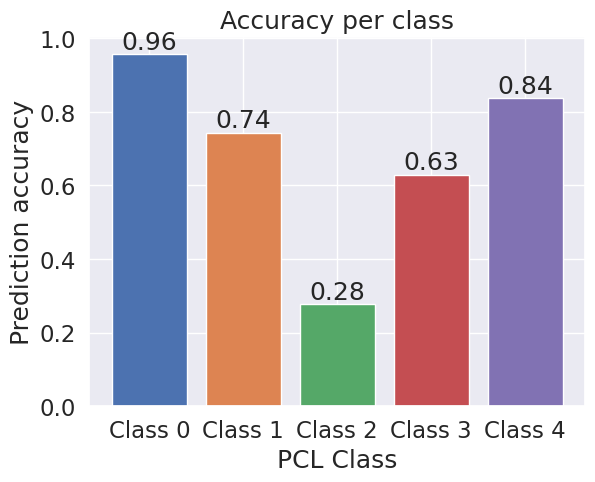

In [ ]:
fig, ax = plt.subplots()
for class_label, accuracy in accuracies.items():
  p = ax.bar(class_label, accuracy)
  ax.bar_label(p, fmt='%.2f')
ax.set_title('Accuracy per class')
ax.set_ylabel('Prediction accuracy')
ax.set_xlabel('PCL Class')
plt.show()

## **Analysis 2**

In [ ]:
# Create a new annotated train_df with text length for each example
analysis2_df = tedf1.copy()
analysis2_df['text_length'] = tedf1['text'].apply(lambda x: len(x))
analysis2_df

,par_id,community,text,label,orig_label,text_length
0,4046,hopeless,We also know that they can benefit by receivin...,1,3,493
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4,197
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2,74
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,218
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3,355
...,...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0,230
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0,172
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0,203
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1,348


In [ ]:
# sorts senquences into bins for comparison of text length
bin_0_100 = analysis2_df[analysis2_df['text_length'] <= 100] # text length 0 - 100
bin_101_200 = analysis2_df[analysis2_df['text_length'] > 100][analysis2_df['text_length'] <= 200] # text length 101 - 200
bin_201_300 = analysis2_df[analysis2_df['text_length'] > 200][analysis2_df['text_length'] <= 300]  # text length 201 - 300
bin_301_400 = analysis2_df[analysis2_df['text_length'] > 300][analysis2_df['text_length'] <= 400]  # text length 301 - 400
bin_401_512 = analysis2_df[analysis2_df['text_length'] > 400][analysis2_df['text_length'] <= 512] # text length 401 - 512
bin_513 = analysis2_df[analysis2_df['text_length'] > 512] # text length 513 +

<ipython-input-294-101e62438adb>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-294-101e62438adb>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-294-101e62438adb>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-294-101e62438adb>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def performance_per_input_length(bin, predictions, test_set):
  get_idx = bin.index.values # get indx for data in that specific bin
  bin_predictions = [] # predictions for that bin
  true_labels = []

  for idx_p, prediction in enumerate(predictions): # index and prediction from dev.txt
    for idx_t in get_idx: # index from class in test set
      if idx_t == idx_p: # find prediction in dev.txt only from specific class
        bin_predictions.append(prediction) # adds the class-specific prediction to the list
        true_label = analysis2_df[analysis2_df.index == idx_t]['label'] # true label from test set
        true_labels.append(true_label)

  # Calculate performance metrics
  accuracy = accuracy_score(true_labels, bin_predictions)
  precision = precision_score(true_labels, bin_predictions)
  recall = recall_score(true_labels, bin_predictions)
  f_one = f1_score(true_labels, bin_predictions)

  return accuracy, precision, recall, f_one

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

bins = [bin_0_100, bin_101_200, bin_201_300, bin_301_400, bin_401_512, bin_513]

for bin in bins:
  accuracy, precision, recall, f_one = performance_per_input_length(bin, predictions, analysis2_df)
  print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f_one}")


Accuracy: 0.9084507042253521, Precision: 0.4375, Recall: 0.6363636363636364, F1-score: 0.5185185185185185
Accuracy: 0.928462709284627, Precision: 0.5454545454545454, Recall: 0.7777777777777778, F1-score: 0.6412213740458015
Accuracy: 0.9265129682997119, Precision: 0.5526315789473685, Recall: 0.711864406779661, F1-score: 0.6222222222222223
Accuracy: 0.8557046979865772, Precision: 0.38636363636363635, Recall: 0.5151515151515151, F1-score: 0.44155844155844154
Accuracy: 0.888235294117647, Precision: 0.6333333333333333, Recall: 0.7037037037037037, F1-score: 0.6666666666666667
Accuracy: 0.9172932330827067, Precision: 0.6111111111111112, Recall: 0.7333333333333333, F1-score: 0.6666666666666666
